In [1]:
%pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
!gdown "1n6IHWly66qSJfxrDSaIBcqm05jo-v6mt"
!gdown "1zToBjksCyT4DYAZ-0Oqj52nEXk0aqtdm"
!gdown "1wKZjFyWcfsTveGpuRwXHqmfFW8Zu8cIe"
!gdown "10S8tYhh1jd5VyQD7Rbw2QVBXIfw3hd1H"
!gdown "1Fs0PTy_xPsoX5bg4QTCrX6JAaQCHRzis"
!gdown "1JLa-ELhUskQINi0syf3YJWBX8jcCXdn4"

Downloading...
From: https://drive.google.com/uc?id=1n6IHWly66qSJfxrDSaIBcqm05jo-v6mt
To: /kaggle/working/rs_train_embeddings.pkl
100%|███████████████████████████████████████| 49.5M/49.5M [00:00<00:00, 157MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zToBjksCyT4DYAZ-0Oqj52nEXk0aqtdm
To: /kaggle/working/rs_test_embeddings.pkl
100%|███████████████████████████████████████| 12.4M/12.4M [00:00<00:00, 100MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wKZjFyWcfsTveGpuRwXHqmfFW8Zu8cIe
To: /kaggle/working/ls_train_embeddings.pkl
100%|███████████████████████████████████████| 49.5M/49.5M [00:00<00:00, 127MB/s]
Downloading...
From: https://drive.google.com/uc?id=10S8tYhh1jd5VyQD7Rbw2QVBXIfw3hd1H
To: /kaggle/working/ls_test_embeddings.pkl
100%|██████████████████████████████████████| 12.4M/12.4M [00:00<00:00, 98.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Fs0PTy_xPsoX5bg4QTCrX6JAaQCHRzis
To: /kaggle/working/train.pkl
100%|█████████████████████████████████████

In [3]:
import pandas as pd
import string
import re
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.isri import ISRIStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.svm import SVC
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from collections import OrderedDict
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.preprocessing import OneHotEncoder
import keras_tuner

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
label_to_class = {
    0: 'none',
    1: 'anger',
    2: 'joy',
    3: 'sadness',
    4: 'love',
    5: 'sympathy',
    6: 'surprise',
    7: 'fear'
}
classes = ['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear']

In [5]:
with open('/kaggle/working/train.pkl', 'rb') as f:
    train = pickle.load(f)

with open('/kaggle/working/test.pkl', 'rb') as f:
    test = pickle.load(f)

with open('/kaggle/working/rs_train_embeddings.pkl', 'rb') as f:
    rs_train_embeddings = pickle.load(f)
    
with open('/kaggle/working/rs_test_embeddings.pkl', 'rb') as f:
    rs_test_embeddings = pickle.load(f)
    
with open('/kaggle/working/ls_train_embeddings.pkl', 'rb') as f:
    ls_train_embeddings = pickle.load(f)
    
with open('/kaggle/working/ls_test_embeddings.pkl', 'rb') as f:
    ls_test_embeddings = pickle.load(f)

In [6]:
train.head()

,tweet,label,tweet_with_out_emojis,cleaned_data,Light Stemming,Root Stemming
1426,شايف نفسه الحمار مع انه كان احتياط الموسم الما...,1,شايف نفسه الحمار مع انه كان احتياط الموسم الما...,شايف الحمار انه احتياط الموسم الماضي اليوفي اد...,شايف الحمار انه احتياط الموسم الماضي اليوفي اد...,شيف حمر انه حيط وسم اضي يوف دره ريل امر غرب هج...
496,: هزق البلد كلها ..مرتضي محدش عارف يوقفه ..ل...,1,: هزق البلد كلها ..مرتضي محدش عارف يوقفه ..ل...,هزق البلد مرتضي محدش عارف يوقفه لا وزير داخليه...,هزق البلد مرتضي محدش عارف يوقفه لا وزير داخليه...,هزق بلد رضي حدش عرف وقف لا وزر دخل شبب حتي بتع...
3464,استفتاء : عندما تنتهي الاوليمبياد وتعود بعثتنا...,0,استفتاء : عندما تنتهي الاوليمبياد وتعود بعثتنا...,استفتاء تنتهي الاوليمبياد وتعود بعثتنا بالسلام...,استفتاء تنتهي الاوليمبياد وتعود بعثت بالسلامه ...,فاء نهي اوليمبياد تعد بعث سلم يدل حصل وجه نظر
7073,Alhashemلا يوجد مخرج لنفط داعش سوي تركيا.هكذا ...,1,Alhashemلا يوجد مخرج لنفط داعش سوي تركيا.هكذا ...,لا يوجد مخرج لنفط داعش سوي تركياهكذا تقول الجغ...,لا يوجد مخرج لنفط داعش سوي تركياهكذا تقول الجغ...,لا وجد خرج نفط دعش سوي تركياهكذا تقل جغراف سؤل...
758,ما احب اركب جاهل معاي السياره عادي اتوتر طول م...,7,ما احب اركب جاهل معاي السياره عادي اتوتر طول م...,احب اركب جاهل معاي السياره عادي اتوتر طول اسوق...,احب اركب جاهل معاي السياره عادي اتوتر طول اسوق...,احب ركب جهل عاي سير عدي وتر طول اسق خيف فرح


In [25]:
X_train = train['Root Stemming']
y_train = train['label']
X_test = test['Root Stemming']
y_test = test['label']

In [26]:
rs_train_embeddings.shape

(8052, 768)

In [27]:
encoder = OneHotEncoder()

y_train = encoder.fit_transform(y_train.values.reshape(-1,1)).toarray()
y_test = encoder.transform(y_test.values.reshape(-1,1)).toarray()

In [28]:
def prepare_tokenization(train, val, test=None, pad=500):
  tokenizer = Tokenizer(oov_token='<UNK>')
  tokenizer.fit_on_texts(train)
  tokenizer.word_index['<PAD>'] = 0
  train = tokenizer.texts_to_sequences(train)
  val = tokenizer.texts_to_sequences(val)
  if not pad==False:
    train = sequence.pad_sequences(train, maxlen=pad)
    val = sequence.pad_sequences(val, maxlen=pad)
  if not type(test)==type(None):
    test = tokenizer.texts_to_sequences(test)
    if not pad==False:
      test = sequence.pad_sequences(test, maxlen=pad)
  v_size = len(tokenizer.word_index)
  print("Vocabulary size={}".format(v_size))
  print("Number of Documents={}".format(tokenizer.document_count))
  if not type(test)==type(None):
    return v_size, train, val, test
  else:
    return v_size, train, val

In [29]:
VOCAB_SIZE, train_sequences, test_sequences = prepare_tokenization(X_train, X_test, pad=False)

Vocabulary size=8546
Number of Documents=8052


(array([6.070e+02, 1.928e+03, 1.988e+03, 1.321e+03, 1.670e+03, 5.040e+02,
        3.200e+01, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  3.7,  7.4, 11.1, 14.8, 18.5, 22.2, 25.9, 29.6, 33.3, 37. ]),
 <BarContainer object of 10 artists>)

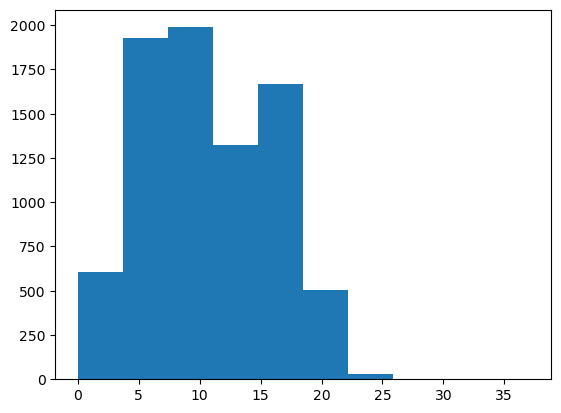

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
plt.hist(train_lens)

In [31]:
max_length = max(train_lens)

In [32]:
max_length

37

In [33]:
X_train = sequence.pad_sequences(train_sequences, maxlen=max_length)
X_test = sequence.pad_sequences(test_sequences, maxlen=max_length)
X_train.shape, X_test.shape

((8052, 37), (2013, 37))

In [34]:
BATCH_SIZE = 32
EPOCHS = 50
EMBED_SIZE = 768#86
LEARNING_RATE =  0.0053516485623658835

early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True)

In [35]:
def build_gru():
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=max_length, trainable=True))#, weights=[rs_train_embeddings]))
    model.add(tf.keras.layers.GRU(256, return_sequences=False))
    model.add(Dropout(0.011691195516528197))
    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(0.0053516485623658835),
                loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [36]:
model = build_gru()

history = model.fit(X_train, np.asarray(y_train), validation_data=(X_test, np.asarray(y_test)), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping_monitor])

Epoch 1/50
252/252 [==============================] - 25s 87ms/step - loss: 1.2474 - accuracy: 0.5669 - val_loss: 1.0132 - val_accuracy: 0.6552
Epoch 2/50
252/252 [==============================] - 4s 16ms/step - loss: 0.6488 - accuracy: 0.7727 - val_loss: 1.1914 - val_accuracy: 0.6284
Epoch 3/50
252/252 [==============================] - 5s 18ms/step - loss: 0.3295 - accuracy: 0.8862 - val_loss: 1.6060 - val_accuracy: 0.5758
Epoch 4/50
252/252 [==============================] - 3s 12ms/step - loss: 0.2050 - accuracy: 0.9307 - val_loss: 2.0161 - val_accuracy: 0.5748
Epoch 5/50
252/252 [==============================] - 3s 13ms/step - loss: 0.1711 - accuracy: 0.9440 - val_loss: 2.2189 - val_accuracy: 0.5822
Epoch 6/50
252/252 [==============================] - 3s 10ms/step - loss: 0.1552 - accuracy: 0.9500 - val_loss: 2.2586 - val_accuracy: 0.5812
Epoch 7/50
252/252 [==============================] - 3s 13ms/step - loss: 0.1883 - accuracy: 0.9370 - val_loss: 2.6728 - val_accuracy: 0.560

In [37]:
predictions = model.predict(X_test)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=classes))

63/63 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

        none       0.61      0.92      0.74       307
       anger       0.54      0.71      0.62       276
         joy       0.61      0.33      0.43       268
     sadness       0.51      0.47      0.49       258
        love       0.74      0.68      0.71       250
    sympathy       0.84      0.70      0.76       194
    surprise       0.53      0.44      0.48       201
        fear       0.95      0.92      0.93       259

    accuracy                           0.66      2013
   macro avg       0.67      0.65      0.64      2013
weighted avg       0.66      0.66      0.65      2013

